In [1]:
%matplotlib notebook

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [35]:
# State

np.random.seed(11)

# Config

xdim = 10
ydim = 1
n = 2000

start = np.array([-3, 0])
end = np.array([3, 0])
loc = (start[0] + end[0]) / 2
scale = end[0]

mindist = 0.6
noise_scale = 10  # use math.inf to ignore

# Generate Points

xs = np.random.normal(size=n, loc=loc, scale=scale)
ys = np.random.normal(size=n) * ydim

ys = np.array([y for x, y in zip(xs, ys) if x > start[0] and x < end[0]])
xs = np.array([x for x in xs if x > start[0] and x < end[0]])

z = np.concatenate([xs.reshape(-1, 1), ys.reshape(-1, 1)], axis=1)
z = np.concatenate([start.reshape(1, 2), z, end.reshape(1, 2)], axis=0)

# Distances

def distance(a, b):
    diff = a - b
    exp = np.power(diff, 2)
    agg = np.sum(exp)
    root = np.sqrt(agg)
    return root

def alldistance(z):
    zdiff = z.reshape(-1, 1, 2) - z.reshape(1, -1, 2)
    zexp = np.power(zdiff, 2)
    zagg = np.sum(zexp, 2)
    zroot = np.sqrt(zagg)
    return zroot

zdist = alldistance(z)

# Shortest Path (by heuristic)

def nextclosest_helper(point, point_index, z, zdist, mindist=0.2):
    x, y = point
    dist = zdist[point_index]
    
    index = np.arange(z.shape[0])
    mask = np.logical_and(z[:, 0] > x, dist > 0)
    mask = np.logical_and(mask, dist >= mindist)
    
    dmask = dist[mask]
    imask = index[mask]
    
    argmin = np.argmin(dmask)

    return imask[argmin]

def nextclosest(point, point_index, z, zdist, mindist=0.3, ntries=3):
    __mindist = mindist
    closest = None
    for i in range(ntries):
        try:
            closest = nextclosest_helper(point, point_index, z, zdist, mindist=__mindist)
        except:
            __mindist = mindist - (mindist / ntries) * (i+1)
    if closest is None:
        raise RuntimeError('Did not find closest point.')
    return closest

def heuristic_path(startindex, endindex, z, zdist, mindist=0.3):
    start = z[startindex]
    end = z[endindex]

    closest = start
    nextindex = 0
    pathindex = [nextindex]

    count = 0

    while True:
        noise = np.random.normal(size=1, scale=mindist/noise_scale)
        __mindist = mindist + noise

        prevclosest = closest
        
        nextindex = nextclosest(closest, nextindex, z, zdist, mindist=__mindist)
        closest = z[nextindex]

        if distance(prevclosest, closest) > distance(prevclosest, end):
            nextindex = endindex
            closest = end
        
        pathindex.append(nextindex)

        if nextindex == z.shape[0] - 1:
            break

        count += 1

        if count > z.shape[0]:
            raise RuntimeError('Loop did not terminate.')

    path = z[pathindex]
    
    return path

path = heuristic_path(0, z.shape[0] - 1, z, zdist, mindist=mindist)

print('Path Length = {}'.format(path.shape[0]))

Path Length = 16


<IPython.core.display.Javascript object>


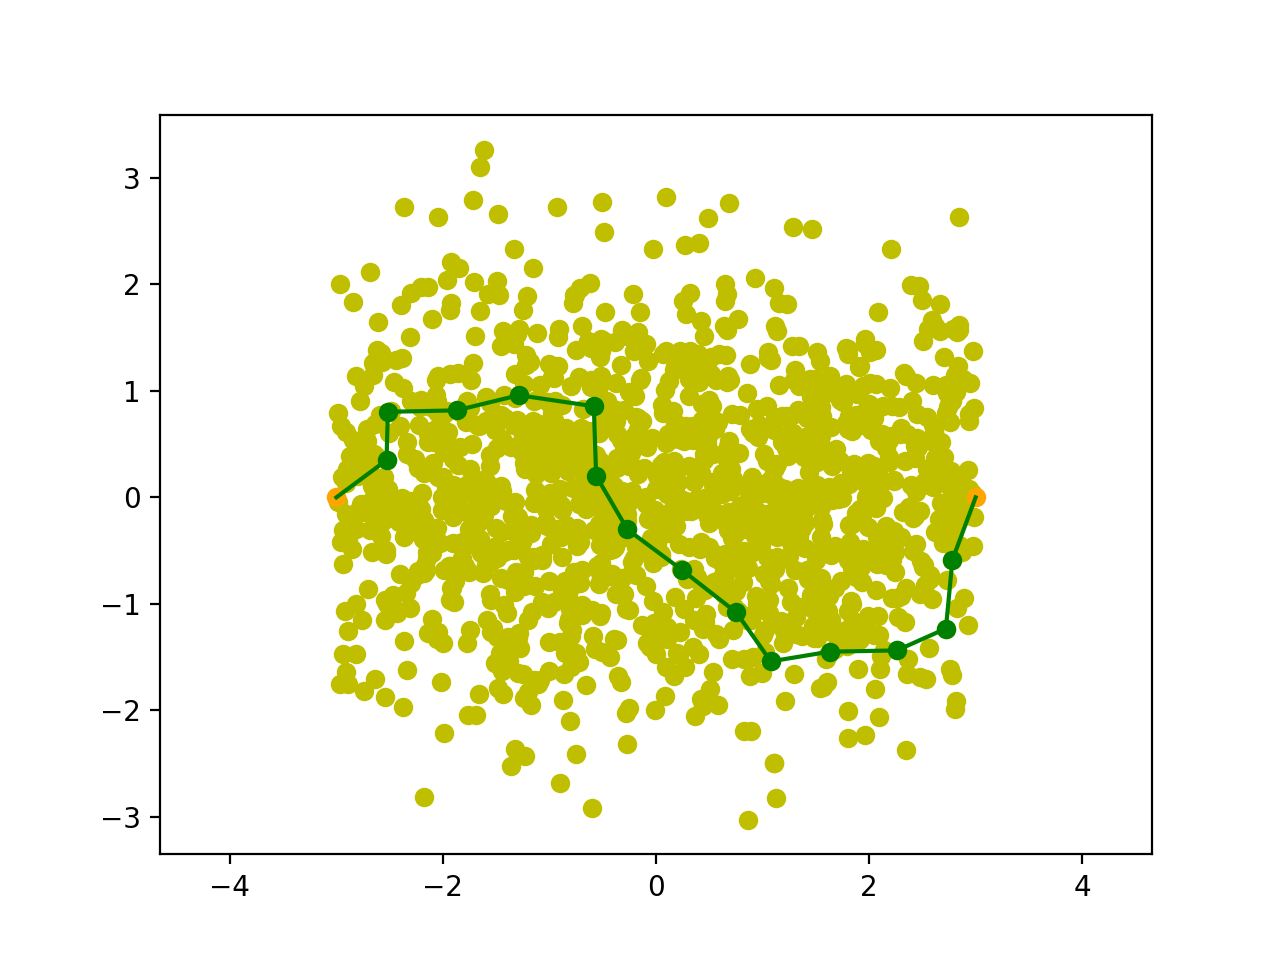

In [36]:
# Visualize

plt.figure()

plt.scatter(xs, ys, color='y')
plt.plot(path[:, 0], path[:, 1], color='g')
plt.scatter(path[1:-1, 0], path[1:-1, 1], color='g')
plt.scatter([start[0], end[0]], [start[1], end[1]], color='orange')

plt.axis('equal')

plt.show()